# Comparing discretization techniques

In Periodic problems and plane-wave discretisations we saw
how simple 1D problems can be modelled using plane-wave basis sets. This example
invites you to work out some details on these aspects yourself using a number of exercises.
The solutions are given at the bottom of the page.

For this example we consider the discretization of
$$
   H = - \frac12 Δ + V(x) \quad \text{with $V(x) = \cos(x)$}
$$
on $[0, 2π]$ with periodic boundary conditions. The $\cos(x)$ takes the role of
a lattice-periodic potential. We will be interested in the smallest eigenvalues
of this discretized Hamiltonian. Of note the boundary condition matters:
The spectrum we will get is different from e.g. the spectrum of $H$ on $\mathbb{R}$.

## Finite differences
We approximate functions $ψ$ on $[0, 2\pi]$ by their values at grid points
$x_k = 2\pi \frac{k}{N}$, $k=1, \dots, N$.
The boundary conditions are imposed by $ψ(x_0) = ψ(x_N), ψ(x_{N+1}) = ψ(x_0)$. We then have
$$
   \big(Hψ\big)(x_k) \approx \frac 1 2 \frac{-ψ_{k-1} + 2 ψ_k - ψ_{k+1}}{2 δx^2}
   + V(x_k) ψ(x_k)
$$
with $δx = \frac{2π}{N}$.

This can be put in matrix form in the following way:

In [1]:
# Finite differences Hamiltonian -1/2 Delta + V on [0, 2pi] with periodic bc.
# Pass it a function V.
using LinearAlgebra

function build_finite_differences_matrix(Vfunction, N::Integer)
    δx = 2π/N

    # Finite-difference approximation to -½Δ
    T = 1/(2δx^2) * Tridiagonal(-ones(N-1), 2ones(N), -ones(N-1))
    # The type Tridiagonal is efficient, but to establish the periodic boundary conditions
    # we need to add elements not on the three diagonals, so convert to dense matrix
    T = Matrix(T)
    T[1, N] = T[N, 1] = -1 / (2δx^2)

    # Finite-difference approximation to potential: We collect all coordinates ...
    x_coords = [k * δx for k=1:N]
    V = Diagonal(Vfunction.(x_coords))  # ... and evaluate V on each of the x_coords

    T + V
end;

!!! tip "Exercise 1"
    Show that the finite-difference approximation of -½Δ is indeed an
    approximation of the second derivative. Obtain an estimate of the first
    eigenvalue of $H$.
    *Hint:* Take a look at the `eigen` function from `LinearAlgebra`.

## Plane waves method

In this method, we expand states on the basis
$$
   e_G(x) = \frac{1}{\sqrt{2\pi}} e^{iGx} \qquad \text{for $G=-N,\dots,N$}.
$$

!!! tip "Exercise 2"
    Show that
    $$
       \langle e_G, e_{G'}\rangle = ∫_0^{2π} e_G(x) e_{G'}(x) d x = δ_{G, G'}
    $$
    and (assuming $V(x) = \cos(x)$)
    $$
       \langle e_G, H e_{G'}\rangle = \frac 1 2 \left(|G|^2 \delta_{G,G'} + \delta_{G, G'+1} + \delta_{G, G'-1}\right).
    $$
    What happens for a more general $V(x)$?

!!! tip "Exercise 3"
    Code this and check the first eigenvalue agrees
    with the finite-difference case. Compare accuracies at various basis set sizes $N$.

## Using DFTK

We now use DFTK to do the same plane-wave discretisation in this 1D system.
To deal with a 1D case we use a 3D lattice with two lattice vectors set to zero.

In [2]:
using DFTK
a = 2π
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

Define Hamiltonian: Kinetic + Potential

In [3]:
terms = [Kinetic(),
         ExternalFromReal(r -> cos(r[1]))]  # r is a vector of size 3
model = Model(lattice; n_electrons=1, terms, spin_polarization=:spinless);  # One spinless electron

Ecut defines the number of plane waves by selecting all those $G$, which satisfy
the relationship $½ |G|^2 ≤ \text{Ecut}$.

In [4]:
Ecut = 500
basis = PlaneWaveBasis(model; Ecut, kgrid=(1, 1, 1))

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. blas  threads   : 2
    num. fft   threads   : 1

    Ecut                 : 500.0 Ha
    fft_size             : (135, 1, 1), 135 total points
    kgrid                : MonkhorstPack([1, 1, 1])
    num.   red. kpoints  : 1
    num. irred. kpoints  : 1

    Discretized Model(custom, 1D):
        lattice (in Bohr)    : [6.28319   , 0         , 0         ]
                               [0         , 0         , 0         ]
                               [0         , 0         , 0         ]
        unit cell volume     : 6.2832 Bohr
    
        num. electrons       : 1
        spin polarization    : spinless
        temperature          : 0 Ha
    
        terms                : Kinetic()
                               ExternalFromReal(Main.var"##238".var"#3#4"())

We now seek the ground state. To better separate the two steps (SCF outer loop
and diagonalization inner loop), we set the diagtol (the tolerance of the eigensolver)
to a small value.

In [5]:
diagtolalg = AdaptiveDiagtol(; diagtol_max=1e-8, diagtol_first=1e-8)
scfres = self_consistent_field(basis; tol=1e-4, diagtolalg)
scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -0.535064852288                   -0.22   13.0    1.82s
  2   -0.535064852288   +  -15.11       -0.91    1.0   37.5ms
  3   -0.535064852288   +    -Inf      -11.79    1.0    611μs


Energy breakdown (in Ha):
    Kinetic             0.2090845 
    ExternalFromReal    -0.7441493

    total               -0.535064852288

On this simple linear (non-interacting) model, the SCF converges in one step.
The ground state energy of is simply the lowest eigenvalue; it should match
the smallest eigenvalue of $H$ computed above.

## Plotting
We can also get the first eigenvector (in the plane wave basis) and plot it

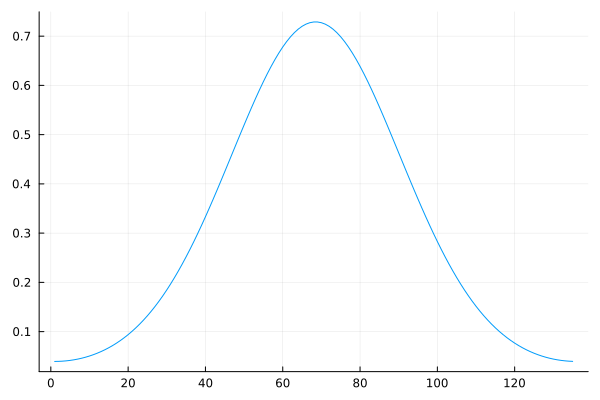

In [6]:
using Plots

ψ_fourier = scfres.ψ[1][:, 1];    # first k-point, all G components, first eigenvector
# Transform the wave function to real space
ψ = ifft(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
# Eigenvectors are only defined up to a phase. We fix it by imposing that psi(0) is real
ψ /= (ψ[1] / abs(ψ[1]))
plot(real(ψ); label="")

Again this should match with the result above.

**Exercise 4:** Look at the Fourier coefficients of $\psi$ ($\psi$_fourier)
and compare with the result above.

## The DFTK Hamiltonian
We can ask DFTK for the Hamiltonian

In [7]:
E, ham = energy_hamiltonian(basis, scfres.ψ, scfres.occupation; ρ=scfres.ρ)
H = ham.blocks[1]
typeof(H)

DFTK.DftHamiltonianBlock

This is an opaque data structure, which encodes the Hamiltonian. What can we do with it?

In [8]:
using InteractiveUtils
methodswith(typeof(H), supertypes=true)

[1] Array(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:74
[2] *(H::HamiltonianBlock, ψ) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:62
[3] (Matrix)(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:75
[4] eltype(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:63
[5] size(block::HamiltonianBlock, i::Integer) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:64
[6] size(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:65
[7] mul!(Hψ::AbstractArray, H::DFTK.DftHamiltonianBlock, ψ::AbstractArray) @ DFTK ~/.julia/packages/TimerOutputs/RsWnF/src/TimerOutput.jl:230
[8] PreconditionerNone(::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/eigen/preconditioners.jl:21
[9] PreconditionerTPA(ham::HamiltonianBlock; kwargs...) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/eigen/preconditioners.jl:45

This defines a number of methods. For instance, it can be used as a linear operator:

In [9]:
H * DFTK.random_orbitals(basis, basis.kpoints[1], 1)

63×1 Matrix{ComplexF64}:
    0.01763258503102002 - 0.05733160997646321im
  -0.008386074976217614 - 0.03511073351711754im
    0.20314116697506834 + 0.052656190218076854im
   -0.16579665800577853 - 0.05736820323107148im
   -0.09870260604138624 - 0.4278359127157623im
      2.132900626993112 - 0.43847689311379556im
    -1.8540997917958355 - 0.25446806563908747im
     0.5497109341163773 - 0.675054770737501im
    -2.5731655688599067 - 1.1296456639750116im
    -11.040924118166823 + 3.0004554352380906im
                        ⋮
     -7.795431202974683 + 0.05890463566699389im
    -1.1627113553433388 - 0.8559177534979233im
     0.6682610771613313 + 0.032588767315625884im
    -0.9340857557086547 + 1.8038883637482601im
     -2.153769662015141 + 1.5240487745638411im
   0.049087872990175946 - 0.1333652034991918im
    0.03461005899895725 - 0.19058008216259878im
   -0.10884152504232761 + 0.07694449000393488im
 -0.0015612932235693766 - 0.07734267574838874im

We can also get its full matrix representation:

In [10]:
Array(H)

63×63 Matrix{ComplexF64}:
  -3.5247e-17+0.0im          …           0.5-4.87133e-17im
          0.5-4.87133e-17im      1.93395e-17+1.19856e-17im
  1.93395e-17+1.19856e-17im     -1.76211e-18+3.43427e-18im
 -1.76211e-18+3.43427e-18im     -5.27235e-18-1.56473e-17im
 -5.27235e-18-1.56473e-17im      1.48093e-17-1.93685e-17im
  1.48093e-17-1.93685e-17im  …   8.85398e-18+4.44201e-18im
  8.85398e-18+4.44201e-18im     -6.82427e-18+6.26594e-18im
 -6.82427e-18+6.26594e-18im       6.5791e-18+9.27972e-18im
   6.5791e-18+9.27972e-18im       1.9934e-18+3.73282e-18im
   1.9934e-18+3.73282e-18im      2.96007e-18-6.58852e-18im
             ⋮               ⋱  
   1.9934e-18-3.73282e-18im      1.84038e-17+2.28001e-19im
  1.84038e-17+2.28001e-19im  …  -6.82427e-18-6.26594e-18im
 -6.82427e-18-6.26594e-18im      8.85398e-18-4.44201e-18im
  8.85398e-18-4.44201e-18im      1.48093e-17+1.93685e-17im
  1.48093e-17+1.93685e-17im     -5.27235e-18+1.56473e-17im
 -5.27235e-18+1.56473e-17im     -1.76211e-18-3.43427e-18

!!! tip "Exercise 5"
    Compare this matrix with the one you obtained previously, get its
    eigenvectors and eigenvalues. Try to guess the ordering of $G$-vectors in DFTK.

!!! tip "Exercise 6"
    Increase the size of the problem, and compare the time spent
    by DFTK's internal diagonalization algorithms to a full diagonalization of `Array(H)`.
    *Hint:* The `@time` macro is handy for this task.

## Solutions

### Exercise 1
If we consider a function $f : [0, 2π] → \mathbb{R}$, to first order
$$
f(x + δx) = f(x) + δx f'(x) + O(δx^2)
$$
therefore after rearrangement
$$
f'(x) = \frac{f(x + δx) - f(x)}{δx} + O(δx).
$$
Similarly
$$
f''(x) = \frac{f'(x + δx) - f'(x)}{δx} + O(δx),
$$
such that overall
$$
f''(x) \simeq \frac{f(x + 2δx) - f(x + δx) - f(x + δx) + f(x)}{δx^2}
       = \frac{f(x + 2δx) - 2f(x + δx) f(x)}{δx^2}
$$
In finite differences we consider a stick basis of vectors
$$
\left\{ e_i = (0, …, 0, \underbrace{δx}_\text{$i$-th position}, 0, …, 0)
        \middle| i = 1, … N \right\}.
$$
Keeping in mind the periodic boundary conditions (i.e. $e_0 = e_N$) projecting the
Hamiltonian $H$ onto this basis thus yields the proposed structure.

!!! note "TODO More details"
    More details needed

We start off with $N = 500$ to obtain

In [11]:
Hfd = build_finite_differences_matrix(cos, 100)
L, V = eigen(Hfd)
L[1:5]

5-element Vector{Float64}:
 -0.5351640695081414
  0.3429576842587494
  0.8532206682511969
  2.053679933442362
  2.078512110605267

This is already pretty accurate (to about 4 digits) as can be estimated looking at
the following convergence plot:

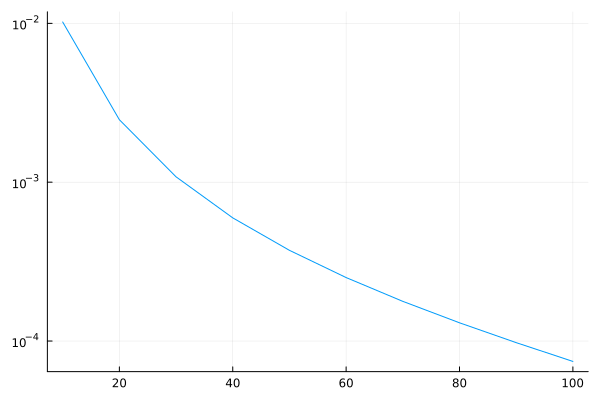

In [12]:
using Plots
function fconv(N)
    L, V = eigen(build_finite_differences_matrix(cos, N))
    first(L)
end
Nrange = 10:10:100
plot(Nrange, abs.(fconv.(Nrange) .- fconv(200)); yaxis=:log, legend=false)

### Exercise 2
!!! note "TODO"
    This solution has not yet been written. Any help with a PR is appreciated.

### Exercise 3
!!! note "TODO"
    This solution has not yet been written. Any help with a PR is appreciated.

### Exercise 4
!!! note "TODO"
    This solution has not yet been written. Any help with a PR is appreciated.

### Exercise 5
!!! note "TODO"
    This solution has not yet been written. Any help with a PR is appreciated.

### Exercise 6
!!! note "TODO"
    This solution has not yet been written. Any help with a PR is appreciated.